# PyTorch-Based SDEs

In this notebook, we simulate the evolution of stock prices using neural Stochastic Differential Equations (SDEs).

In [1]:
from datetime import datetime
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)
plt.style.use("dark_background")

In [2]:
from neural_sde import infer_heston_parameters, Heston, GeometricBrownianMotion
from market_data import get_samples

## Retrieve Market Data

Each SDE will be fit on the (joint) evolution of real-world stock prices over `PREDICTION_PERIOD` trading days.

In [3]:
STOCK_NAMES = ["AMZN", "GOOGL", "MSFT"]
PREDICITON_PERIOD = 6 * 20  # 6 months
INTERVAL = "1d"  # daily closing prices

We will fit `NUM_SAMPLES` SDEs on `NUM_SAMPLES` trajectories observed between `START` and `END`.

In [4]:
NUM_SAMPLES = 1000
START = datetime(2010, 1, 1)
END = datetime(2020, 1, 1)

The Heston SDE will also depend on an observed local volatility process. We define the local volatility as the volatility of the stock price over `LOCAL_WINDOW_SIZE` days.

In [5]:
LOCAL_WINDOW_SIZE = 5

So, let us download the specified market data:

In [6]:
actual_samples = get_samples(STOCK_NAMES, NUM_SAMPLES, START, END, INTERVAL, LOCAL_WINDOW_SIZE, PREDICITON_PERIOD)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


and have a look at it:

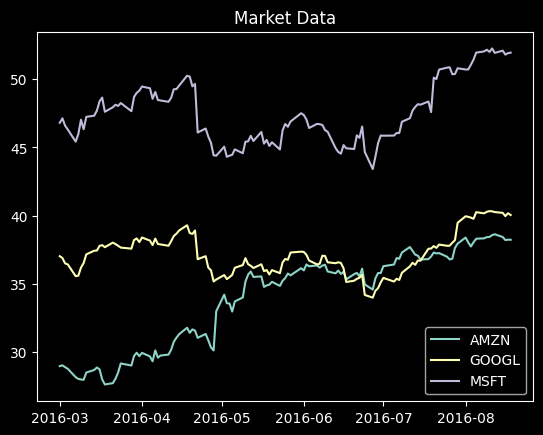

In [7]:
trajectories = []

for market_data in actual_samples:
    
    for j, stock_name in enumerate(STOCK_NAMES):
        stock_prices = market_data[j]["S"]
        
        plt.plot(stock_prices.index, stock_prices, label=stock_name)
    
    break

plt.legend()
plt.title("Market Data")
plt.show()

## Calibrate and Solve Neural SDEs

From each trajectory, we can infer the parameters of a Heston (or Geometric Brownian Motion) SDE.

Once the parameters are fixed, we can solve the SDE (with step size `DT`) and thereby get a sample (of size `NUM_SIMULATIONS`) of the paths solving the SDE.

In [8]:
DT = 1
NUM_SIMULATIONS = 128

In [9]:
trajectories = []

for observed_processes in actual_samples:
    
    heston_parameters = infer_heston_parameters(observed_processes)
    gbm_parameters = {
        "mu": heston_parameters["rs"],
        "sigma": np.sqrt(heston_parameters["thetas"]),
        "lambdas": heston_parameters["lambdas"]
        }

    heston = Heston(**heston_parameters)
    heston_sde_predictions = heston.predict(observed_processes, num_simulations=NUM_SIMULATIONS, dt=DT)

    gbm = GeometricBrownianMotion(**gbm_parameters)
    gbm_sde_predictions = gbm.predict(observed_processes, num_simulations=NUM_SIMULATIONS, dt=DT)

    index = observed_processes[0].index

    actual = {}
    heston_predictions = []
    gbm_predictions = []
    for k in range(NUM_SIMULATIONS):
        heston_prediction = {}
        gbm_prediction = {}
        for j, stock_name in enumerate(STOCK_NAMES):
            heston_prediction[stock_name] = heston_sde_predictions[:, k, 2 * j]
            gbm_prediction[stock_name] = gbm_sde_predictions[:, k, j]
            if k == 0:
                actual[stock_name] = observed_processes[j]["S"]
        heston_predictions.append(pd.DataFrame(heston_prediction, index=index))
        gbm_predictions.append(pd.DataFrame(gbm_prediction, index=index))
    actual = pd.DataFrame(actual, index=index)
    
    trajectories.append({
        "actual": actual,
        "heston": heston_predictions,
        "gbm": gbm_predictions,
        "heston_parameters": heston_parameters,
        "gbm_parameters": gbm_parameters
        })

## Visual Checks

Now, we can have a look at the predictions.
* The purple path is the real-world stock price, on which the SDE has been calibrated.
* The red paths are predicted paths that (as an ensemble) solve the SDE.

In [10]:
NUM_PLOTS = 3
NUM_DATAPOINTS = 16

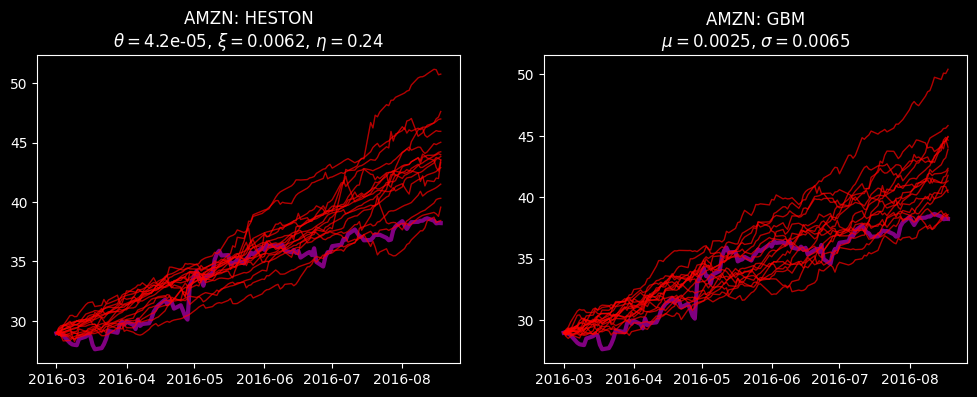

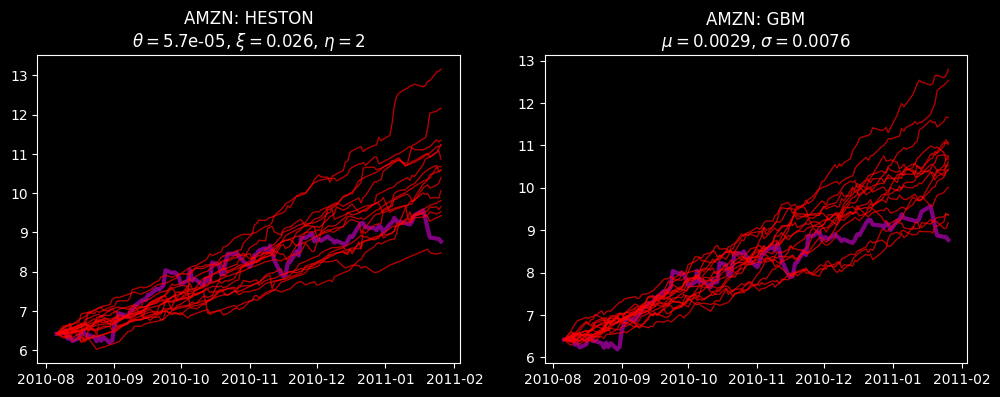

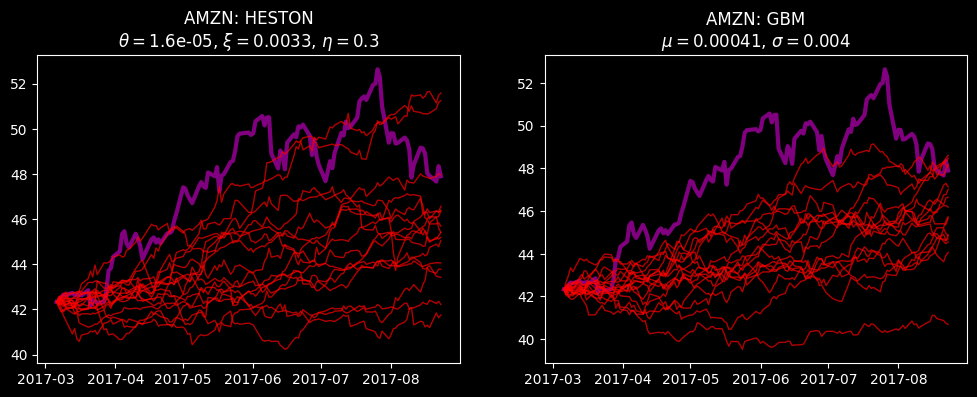

In [11]:
for trajectory in trajectories[:NUM_PLOTS]:
    
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(4)
    fig.set_figwidth(12)

    actual = trajectory["actual"]
    stock_name = STOCK_NAMES[0]

    for k, method in enumerate(["heston", "gbm"]):
        
        predictions = trajectory[method]
        parameters = trajectory[method + "_parameters"]
        
        axs[k].plot(actual.index, actual[stock_name], c="purple", linewidth=3, alpha=1)
        for prediction in predictions[:NUM_DATAPOINTS]:
            axs[k].plot(prediction.index, prediction[stock_name], c="red", linewidth=1, alpha=.7)
    
        title_string = ", ".join([f"$\\{p.rstrip('s')}=${parameters[p][0]:.2g}" for p in parameters if p not in ("lambdas", "rs")])
        axs[k].set_title(f"{stock_name}: {method.upper()}\n{title_string}")

    plt.show()

Are these predictions accurate? For sure, we want the predicted terminal states of the stock price to match the real-world one.

Mean Relative Errors:
Heston: 0.054
Geometric Brownian Motion: 0.053


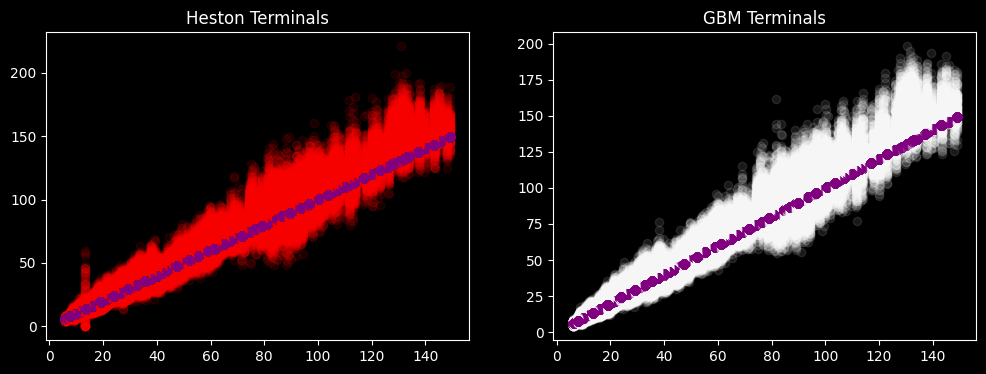

In [12]:
heston_error, gbm_error = [], []

fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(12)

axs[0].set_title("Heston Terminals")
axs[1].set_title("GBM Terminals")

for trajectory in trajectories:
    actual, heston, gbm = trajectory["actual"], trajectory["heston"], trajectory["gbm"]
    heston_terminals = np.array([prediction.iloc[-1] for prediction in heston])
    gbm_terminals = np.array([prediction.iloc[-1] for prediction in gbm])
    actual_terminals = np.array([actual.iloc[-1]] * len(heston_terminals))
    axs[0].scatter(actual_terminals, heston_terminals, color="red", alpha=.1)
    axs[0].scatter(actual_terminals, actual_terminals, color="purple")
    axs[1].scatter(actual_terminals, gbm_terminals, color="white", alpha=.1)
    axs[1].scatter(actual_terminals, actual_terminals, color="purple")
    heston_error.append((heston_terminals - actual_terminals) / actual_terminals)
    gbm_error.append((gbm_terminals - actual_terminals) / actual_terminals)

print("Mean Relative Errors:")
print(f"Heston: {np.mean(heston_error):.3f}")
print(f"Geometric Brownian Motion: {np.mean(gbm_error):.3f}")

But we are not only interested in the terminal state of the stock price, so let's have a look at $S_t/S_0$ `for t in range(0, PREDICTION_PERIOD)`.

t = 24, i = 0:
actual: [0.947, 1.022, 1.098]
predicted: [0.971, 1.031, 1.091]
t = 24, i = 1:
actual: [0.947, 1.022, 1.098]
predicted: [0.974, 1.031, 1.087]


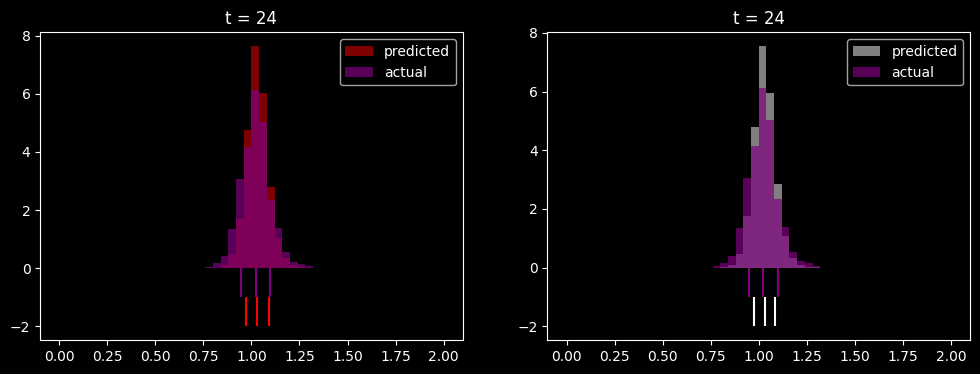

t = 48, i = 0:
actual: [0.941, 1.043, 1.145]
predicted: [0.963, 1.064, 1.166]
t = 48, i = 1:
actual: [0.941, 1.043, 1.145]
predicted: [0.965, 1.064, 1.164]


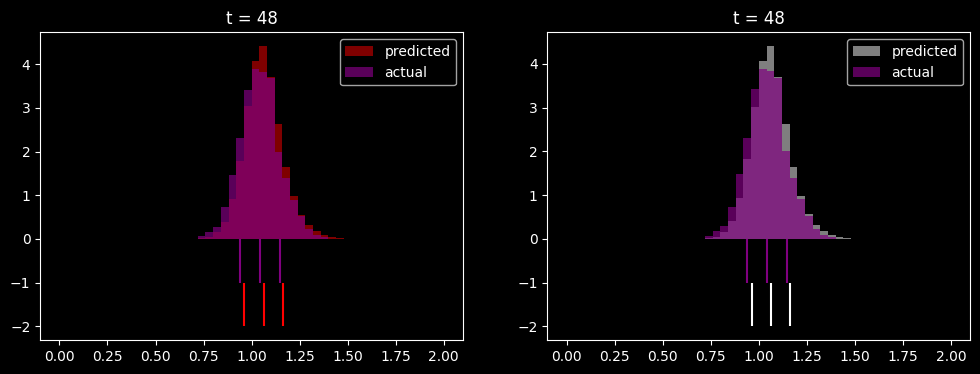

t = 72, i = 0:
actual: [0.942, 1.066, 1.189]
predicted: [0.954, 1.1, 1.247]
t = 72, i = 1:
actual: [0.942, 1.066, 1.189]
predicted: [0.955, 1.1, 1.245]


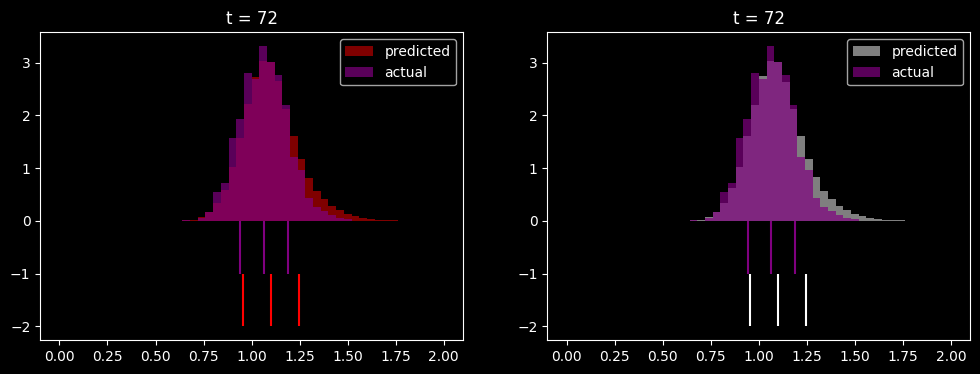

t = 96, i = 0:
actual: [0.951, 1.09, 1.228]
predicted: [0.944, 1.139, 1.334]
t = 96, i = 1:
actual: [0.951, 1.09, 1.228]
predicted: [0.945, 1.139, 1.333]


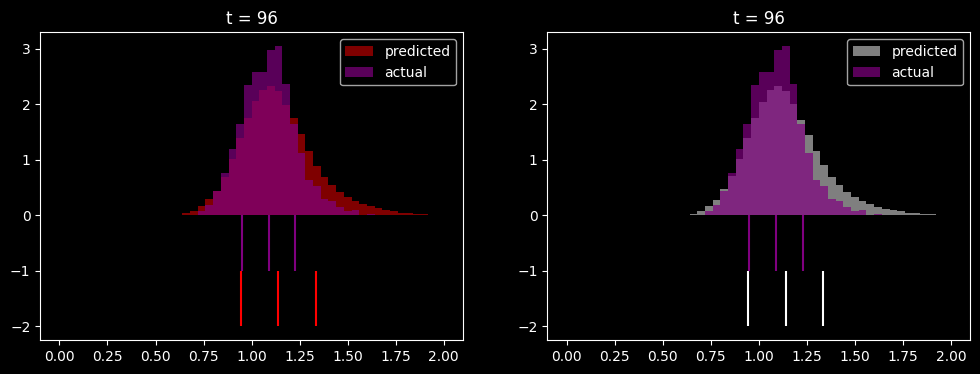

In [13]:
actual_distribution, heston_distribution, gbm_distribution = defaultdict(list), defaultdict(list), defaultdict(list)
time_range = range(PREDICITON_PERIOD // 5, PREDICITON_PERIOD, PREDICITON_PERIOD // 5)
colors = ["red", "white"]

for trajectory in trajectories:
    actual, heston, gbm = trajectory["actual"], trajectory["heston"], trajectory["gbm"]
    for t in time_range:
        for stock_name in STOCK_NAMES:
            actual_distribution[t].append(actual[stock_name].iloc[t] / actual[stock_name].iloc[0])
            for heston_prediction in trajectory["heston"]:
                heston_distribution[t].append(heston_prediction[stock_name].iloc[t] / heston_prediction[stock_name].iloc[0])
            for gbm_prediction in trajectory["gbm"]:
                gbm_distribution[t].append(gbm_prediction[stock_name].iloc[t] / gbm_prediction[stock_name].iloc[0])


def vlines(distribution):
    mean = np.mean(distribution)
    std = np.std(distribution)
    return [mean - std, mean, mean + std]


for t in time_range:
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    for i, distribution in enumerate([heston_distribution, gbm_distribution]):
        axs[i].hist(distribution[t], range=(0, 2), bins=50, histtype="stepfilled", density=True, color=colors[i], alpha=.5, label="predicted")
        axs[i].vlines(vlines(distribution[t]), ymin=-2, ymax=-1, color=colors[i])
        axs[i].hist(actual_distribution[t], range=(0, 2), bins=50, histtype="stepfilled", density=True, color="purple", alpha=.7, label="actual")
        axs[i].vlines(vlines(actual_distribution[t]), ymin=-1, ymax=0, color="purple")
        axs[i].set_title(f"t = {t}")
        axs[i].legend()
        print(f"t = {t}, i = {i}:")
        print(f"actual: {[float(round(x, 3)) for x in vlines(actual_distribution[t])]}")
        print(f"predicted: {[float(round(x, 3)) for x in vlines(distribution[t])]}")
    plt.show()

## Application: Pricing an Autocallable

Once we are happy with what our predictions look like, we can use the SDEs to simulate stock prices and thereby compute the payoff of an autocallable.

In [14]:
STRIKE = 1.0
KNOCKIN_LEVEL = .8
KNOCKOUT_LEVEL = 1.0

NUM_COUPON_DATES = PREDICITON_PERIOD // 20
NUM_KNOCKOUT_DATES = PREDICITON_PERIOD // 20

COUPON = .095  * (30 / 360)
NOTIONAL = 1000

In [15]:
def autocallable_payoff(price_df):
    """Compute payoff of autocallable."""
    
    dates = price_df.index
    initial_prices = price_df.iloc[0]
    knockin_barriers = KNOCKIN_LEVEL * initial_prices
    knockout_barriers = KNOCKOUT_LEVEL * initial_prices
    
    coupon_date_indices = range(-1, -len(dates), -len(dates) // NUM_COUPON_DATES)
    assert len(coupon_date_indices) == NUM_COUPON_DATES
    coupon_dates = dates[coupon_date_indices]
    
    knockout_date_indices = range(-1, -len(dates), -len(dates) // NUM_KNOCKOUT_DATES)
    assert len(knockout_date_indices) == NUM_KNOCKOUT_DATES
    knockout_dates = dates[knockout_date_indices]

    knock_in = False
    coupon_payoff = .0

    for date, prices in price_df.iterrows():
        if (prices <= knockin_barriers).any():
            knock_in = True
        if date in coupon_dates:
            coupon_payoff += NOTIONAL * COUPON
        if date in knockout_dates and (prices >= knockout_barriers).all():
            return NOTIONAL + coupon_payoff
    
    if knock_in:
        knock_in_factor = min(1, (prices / (STRIKE * initial_prices)).min())
        final_payoff = knock_in_factor * NOTIONAL
    else:
        final_payoff = NOTIONAL
    return final_payoff + coupon_payoff

For each price evolution observed on the market and for each prediction, we compute the payoff of the autocallable.

In [16]:
actual_payoffs = []
heston_payoffs = []
gbm_payoffs = []

for trajectory in tqdm(trajectories):

    actual_path = trajectory["actual"]
    heston_paths = trajectory["heston"]
    gbm_paths = trajectory["gbm"]

    heston_payoffs.extend([autocallable_payoff(heston_path) for heston_path in heston_paths])
    gbm_payoffs.extend([autocallable_payoff(gbm_path) for gbm_path in gbm_paths])
    actual_payoffs.extend([autocallable_payoff(actual_path)] * len(heston_paths))

actual_payoffs, heston_payoffs, gbm_payoffs = map(np.array, [actual_payoffs, heston_payoffs, gbm_payoffs])

gbm_differences = actual_payoffs - gbm_payoffs
heston_differences = actual_payoffs - heston_payoffs


100%|██████████| 1000/1000 [09:13<00:00,  1.81it/s]


Then, we can plot the Value At Risk of the autocallable, according to the SDE or according to the real-world prices.

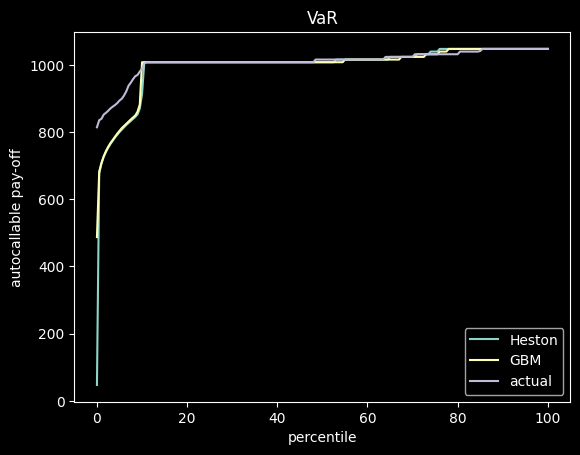

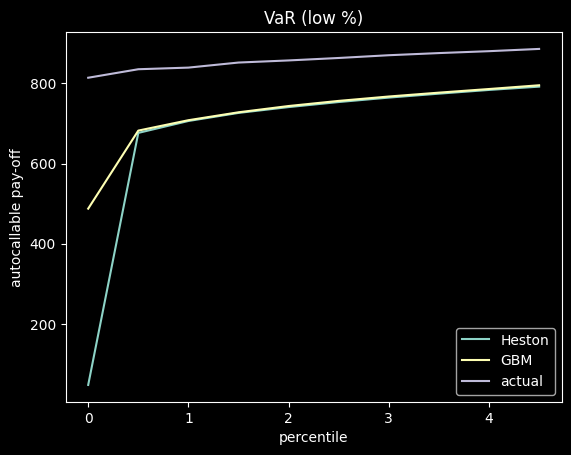

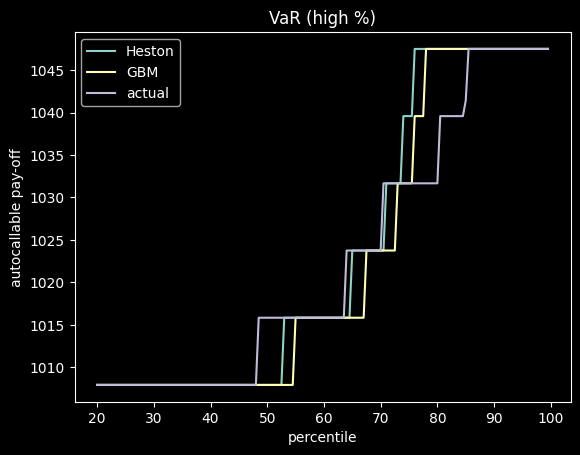

In [17]:
qs = np.arange(0, 100.5, .5)
actual_vars, heston_vars, gbm_vars = [], [], []

for q in qs:
    actual_vars.append(np.percentile(actual_payoffs, q))
    heston_vars.append(np.percentile(heston_payoffs, q))
    gbm_vars.append(np.percentile(gbm_payoffs, q))

vars = {"Heston": heston_vars, "GBM": gbm_vars, "actual": actual_vars}
plot_config = {"": (0, len(qs)), " (low %)": (0, 10), " (high %)": (- 8 * len(qs) // 10, -1)}

for title, q_range in plot_config.items():
    for label, var_array in vars.items():
        plt.plot(qs[q_range[0]: q_range[1]], var_array[q_range[0]: q_range[1]], alpha=1, label=label)
    plt.xlabel("percentile")
    plt.ylabel("autocallable pay-off")
    plt.title("VaR" + title)
    plt.legend()
    plt.show()